# Training a CNN-LSTM Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import math
import os
from typing import Callable, List, Optional

import numpy as np
import pandas as pd
import tensorflow as tf
from official.nlp.modeling.layers.position_embedding import RelativePositionEmbedding
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
%pwd

'/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks/TF_model_benchmarks/cnn_model_on_pride'

In [6]:
DATA_SOURCE = 'pride'
# DATA_SOURCE = 'pdeep'

In [7]:
PROJECT = "PXD010000"

if DATA_SOURCE == 'pride':
    DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)
    TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
    FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
elif DATA_SOURCE == 'pdeep':
    DUMP_PATH = "/scratch/mirko.krause/pdeep"
    TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
    FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")
else:
    assert False

In [8]:
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

In [9]:
SEQ = 'peptide_sequence'

In [10]:
logger = log.create_logger(
    name='mmproteo_cnn_lstm',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-10-24 12:12:37,187 - mmproteo_cnn_lstm: Logging to file '/scratch/mirko.krause/dumps/PXD010000/mmproteo_cnn_lstm.log' and to stderr


In [11]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'2': 'A',
  '3': 'C',
  '4': 'D',
  '5': 'E',
  '6': 'F',
  '7': 'G',
  '8': 'H',
  '9': 'I',
  '10': 'K',
  '11': 'L',
  '12': 'M',
  '13': 'M(Oxidation)',
  '14': 'N',
  '15': 'P',
  '16': 'Q',
  '17': 'R',
  '18': 'S',
  '19': 'T',
  '20': 'V',
  '21': 'W',
  '22': 'Y',
  '0': '_',
  '1': 'EOS'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f68e0932ca0>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(2354,), dtype=tf.float32, name=None), TensorSpec(shape=(2354,), dtype=tf.float32, name=None)), (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))',
 'eos_idx': 1}

In [12]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [13]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-2

In [14]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [15]:
KEEP_CACHE = True

In [16]:
TRAIN_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [17]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns'] or []])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAIN_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 190
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_B_bifidum_CMcarb_anaerobic_03_26Feb16_Arwen_16-01-01_mzmlid.parquet/Bifidobacterium_bifidum_ATCC29521/Train
#Test = 24
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_F_novicida_TSB_aerobic_03_01Feb16_Arwen_15-07-13_mzmlid.parquet/Francisella_novicida_U112/Train
#Eval = 21
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/S_venezuelae_GYM_1_21Mar16_Arwen_16-01-03_mzmlid.parquet/Streptomyces_venezuelae/Train


2021-10-24 12:12:37,211 - mmproteo_cnn_lstm: found file paths dump '/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [18]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name=None),
  TensorSpec(shape=(2354,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))

In [19]:
BATCH_SIZE=32

In the following step, Tensorflow starts allocating GPUs and GPU memory

In [20]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-10-24 12:12:37,221 - mmproteo_cnn_lstm: DEBUG: started initializing tensorflow by creating a first dataset
2021-10-24 12:18:57,029 - mmproteo_cnn_lstm: finished initializing tensorflow


In [21]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [22]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-10-24 12:18:57,054 - mmproteo_cnn_lstm: DEBUG: preparing dataset 'Train' with 190 paths
2021-10-24 12:18:57,064 - mmproteo_cnn_lstm: DEBUG: applied options to dataset 'Train'
2021-10-24 12:18:57,119 - mmproteo_cnn_lstm: DEBUG: loaded dataset 'Train' interleaved
2021-10-24 12:18:57,120 - mmproteo_cnn_lstm: DEBUG: skipped caching dataset 'Train'
2021-10-24 12:18:57,120 - mmproteo_cnn_lstm: DEBUG: shuffled dataset 'Train'
2021-10-24 12:18:57,121 - mmproteo_cnn_lstm: DEBUG: batched dataset 'Train'
2021-10-24 12:18:57,121 - mmproteo_cnn_lstm: DEBUG: configured prefetching for dataset 'Train'
2021-10-24 12:18:57,122 - mmproteo_cnn_lstm: DEBUG: skipped benchmarking dataset 'Train'
2021-10-24 12:18:57,122 - mmproteo_cnn_lstm: prepared dataset 'Train'
2021-10-24 12:18:57,122 - mmproteo_cnn_lstm: DEBUG: preparing dataset 'Test' with 24 paths
2021-10-24 12:18:57,123 - mmproteo_cnn_lstm: DEBUG: applied options to dataset 'Test'
2021-10-24 12:18:57,131 - mmproteo_cnn_lstm: DEBUG: loaded datase

{'Train': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

## Building the Tensorflow Model

In [23]:
from tensorflow.python.keras.metrics import MeanMetricWrapper
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.keras import backend
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

In [24]:
def jaccard_distance(elem):
    i_true, i_pred = elem[0], elem[1]
    unique_true, _ = tf.unique(i_true)
    unique_pred, _ = tf.unique(i_pred)
    n_unique_true = tf.shape(unique_true)[0]
    n_unique_pred = tf.shape(unique_pred)[0]
    unique_all, _ = tf.unique(tf.concat(values=[unique_true, unique_pred], axis=-1))
    n_unique_all = tf.shape(unique_all)[0]
    n_overlap = n_unique_true + n_unique_pred - n_unique_all
    return n_overlap / n_unique_all

def jaccard_batch_distance(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
            backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    jaccard = tf.map_fn(fn=jaccard_distance, elems=(y_true, y_pred), fn_output_signature=tf.float64)
    return math_ops.cast(jaccard, backend.floatx())
    

class JaccardBatchDistance(MeanMetricWrapper):
    def __init__(self, name='jaccard_batch_distance', dtype=None):
        super(JaccardBatchDistance, self).__init__(
            jaccard_batch_distance, name, dtype=dtype)

In [25]:
def leuvenshtein_sparse_tensor_batch_distance(y_true: tf.sparse.SparseTensor, y_pred: tf.sparse.SparseTensor) -> tf.Tensor:
    return tf.edit_distance(
        hypothesis=y_pred,
        truth=y_true,
        normalize=False,
    )

def leuvenshtein_batch_distance(y_true: tf.Tensor, y_pred: tf.Tensor, sparse_pred: bool = True) -> tf.Tensor:
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    
    if sparse_pred:
        y_pred = math_ops.argmax(y_pred, axis=-1)
    
    y_pred = tf.sparse.from_dense(y_pred)
    y_true = tf.sparse.from_dense(y_true)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    leuvenshtein = leuvenshtein_sparse_tensor_batch_distance(y_true, y_pred)
    return math_ops.cast(leuvenshtein, backend.floatx())
    

class LeuvenshteinBatchDistance(MeanMetricWrapper):
    def __init__(self, name='leuvenshtein_batch_distance', dtype=None):
        super(LeuvenshteinBatchDistance, self).__init__(
            leuvenshtein_batch_distance, name, dtype=dtype)

In [26]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_intensity_array')>]


In [27]:
def build_lstm_with_pooling_and_position_model(
    model_name: str = "mmproteo_lstm_with_pooling_and_position"
) -> tf.keras.Model:
    input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
        [
            layers.InputLayerConfiguration(
                name=col,
                shape=PROCESSING_INFO['padding_lengths'][col],
                mask_value=PROCESSING_INFO['padding_characters'][col]
            )
            for col in PROCESSING_INFO['training_data_columns']
        ]
    )
    
    x = tf.stack(
        values=input_layers_list, 
        axis=-1,
    )
    
    position_embedding = RelativePositionEmbedding(
        hidden_size=12,
        name='relative_position_embedding'
    )(x)
    position_embedding = tf.expand_dims(position_embedding, 0)
    position_embedding = tf.broadcast_to(
        input=position_embedding, 
        shape=(tf.shape(x)[0], *tf.shape(position_embedding)[1:])
    )
    
    y_layers=[position_embedding]
    
    dense_y = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=32,
            activation='relu',
            name='y_time_distributed_dense',
        )
    )(x)
    y_layers.append(dense_y)
    

    for i in range(4):
        filter_count = 16 * (i+1)
        kernel_size = 4 ** min(i, 3)
        cnn_y = tf.keras.layers.Conv1D(
            filters=filter_count,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            name=f"y_conv_{kernel_size}_{filter_count}",
        )(x)
        y_layers.append(cnn_y)
    
    x = tf.concat(
        values=y_layers,
        axis=-1
    )
    
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=256,
            return_sequences=True,
            name='lstm'
        )
    )(x)
    
    x = tf.keras.layers.GlobalMaxPooling1D(
        name='global_max_pooling_over_time',
    )(x)
    
    x = tf.keras.layers.Dense(
        units=1024,
        activation='relu',
        name=f"upscaling_dense_{i}",
    )(x)
    
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ] * 8,
        activation='relu',
        name="final_dense_layer_to_redefine_lengths",
    )(x)
    
    x = tf.reshape(x, (-1, PROCESSING_INFO['padding_lengths'][SEQ], 8))
    
    x = tf.keras.layers.LSTM(
        units=len(idx_to_char),
        return_sequences=True,
        name='final_lstm'
    )(x)
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{DATA_SOURCE}_{utils.get_current_time_str()}"
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=10**-4
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            JaccardBatchDistance(),
            LeuvenshteinBatchDistance(),
        ]
    )
    
    return model

In [28]:
model = build_lstm_with_pooling_and_position_model()

In [29]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_pride_20211024-121858'

In [30]:
utils.ensure_dir_exists(MODEL_PATH)

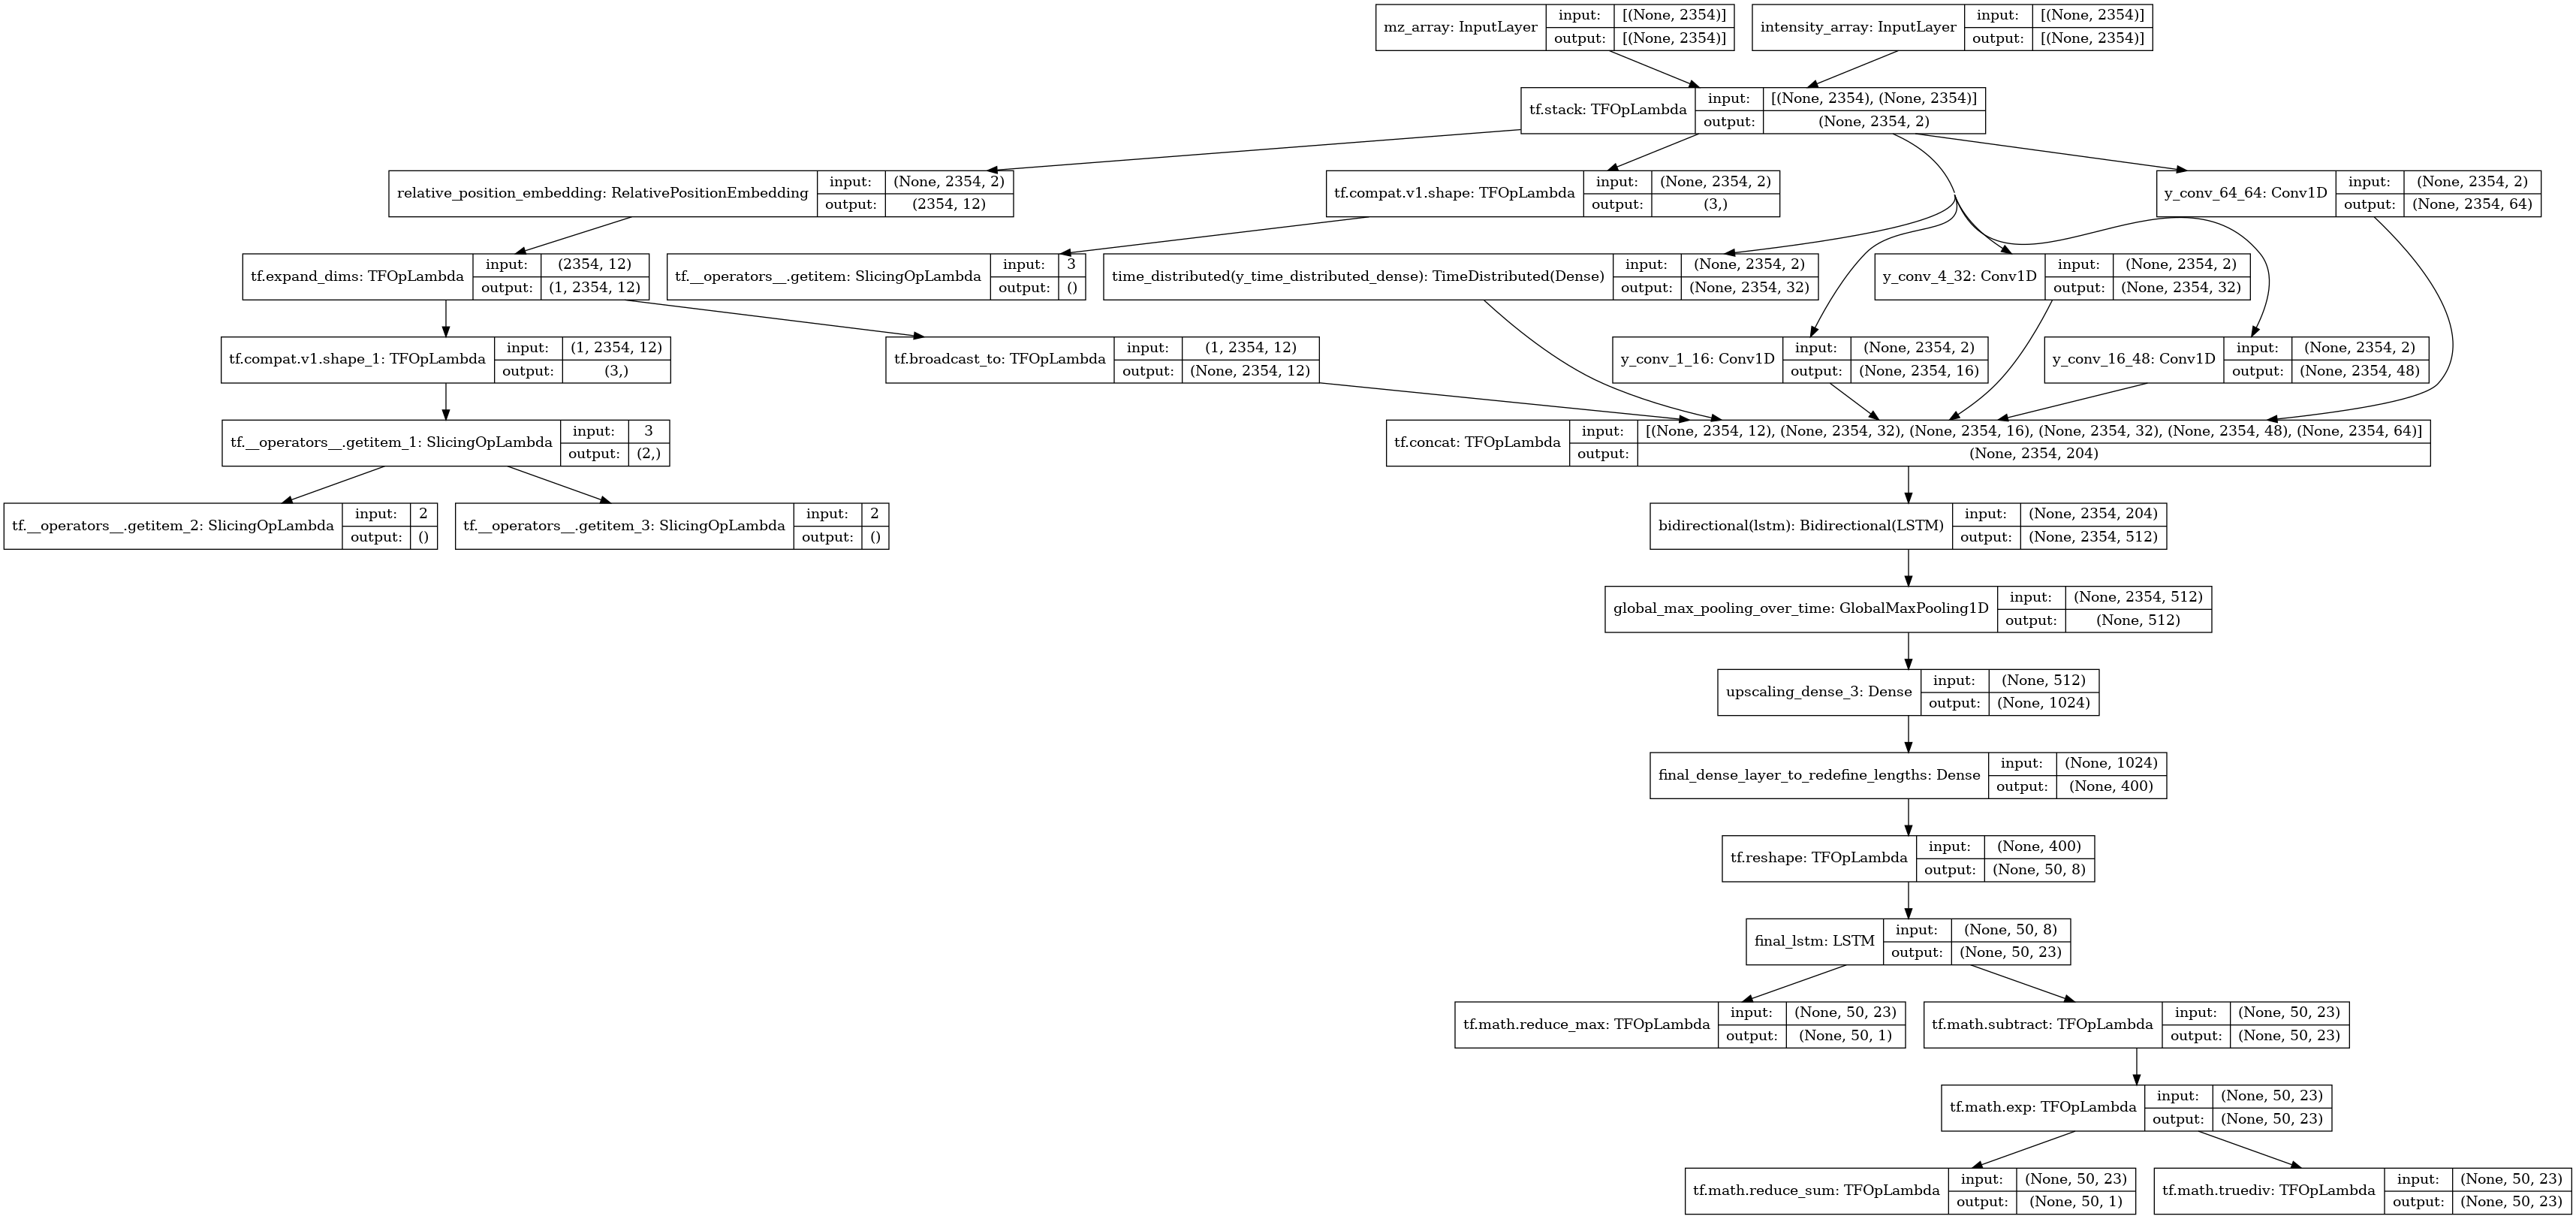

In [31]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [32]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_lstm_with_pooling_and_position_pride_20211024-121858"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 2354)]       0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 2354)]       0                                            
__________________________________________________________________________________________________
tf.stack (TFOpLambda)           (None, 2354, 2)      0           mz_array[0][0]                   
                                                                 intensity_array[0][0]            
__________________________________________________________________________________________________
relative_position_embedding (Re (2354,

In [33]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [34]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

## Training the Tensorflow Model

In [35]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=False,
            csv=True,
            base_path=MODEL_PATH,
)
callback_list

In [36]:
training_dataset = datasets[TRAIN_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [41]:
STEPS_PER_EPOCH = 5_000

In [ ]:
model.fit(
    x=training_dataset,
    validation_data=validation_dataset, 
    validation_steps=STEPS_PER_EPOCH // 5,
    epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callback_list
)

Epoch 1/100
 864/5000 [====>.........................] - ETA: 20:53 - loss: 1.9895 - sparse_categorical_accuracy: 0.7077 - jaccard_batch_distance: 0.2740 - leuvenshtein_batch_distance: 13.2660

## Evaluating the Tensorflow Model

In [ ]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

eval_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[TRAIN_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [ ]:
train_evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
eval_evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = eval_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
%%javascript
Jupyter.notebook.session.delete();